In [1]:
import datetime
import json
from urllib.request import urlopen

import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line

import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
from jupyter_dash import JupyterDash

In [15]:
state_count = pd.read_csv("state_case.csv")

## Case count dataset processing

In [16]:
state_count = state_count[['state','submission_date','new_case','new_death']]
state_count = state_count.rename(columns = {'submission_date':'date'})
state_count['date'] = pd.to_datetime(state_count['date'])

In [17]:
state_count['month'] = pd.to_datetime(state_count['date']).dt.month
state_count_monthly = state_count.groupby(['state','month']).sum().reset_index()

In [18]:
state_count_monthly

,state,month,new_case,new_death
0,AK,1,0,0
1,AK,2,0,0
2,AK,3,133,3
3,AK,4,222,6
4,AK,5,105,1
...,...,...,...,...
715,WY,8,1116,11
716,WY,9,2106,13
717,WY,10,7350,37
718,WY,11,20007,128


In [19]:
state_count_Oct = state_count_monthly[state_count_monthly['month'] == 10]

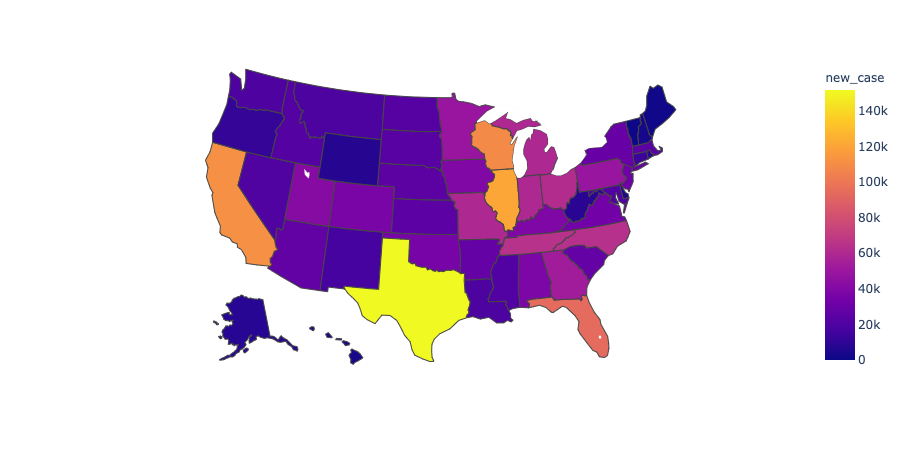

In [20]:
fig = px.choropleth(state_count_Oct, color = 'new_case', locations='state', locationmode="USA-states", scope="usa")
fig.show()

In [21]:
CA_case_count = state_count[state_count['state'] == 'CA']
TX_case_count = state_count[state_count['state'] == 'TX']

In [132]:
a= CA_case_count['new_case'].tolist()
a.sort()

In [134]:
a[-1]

22018

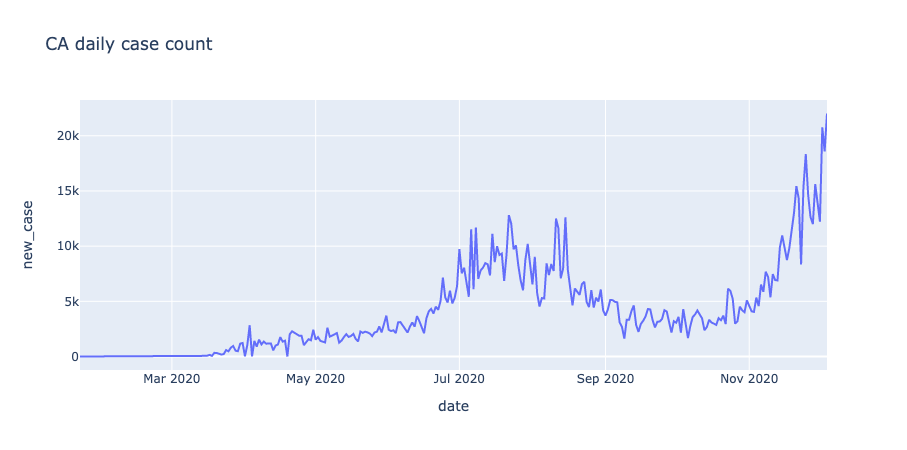

In [22]:
CA_fig = px.line(CA_case_count, x = CA_case_count['date'], y = CA_case_count['new_case'], 
                 title='CA daily case count')
CA_fig.show()

## State mandate processing

In [37]:
state_mandate = pd.read_csv("state_mandates.csv")

In [38]:
state_mandate

,state_id,policy_level,date,policy_type,start_stop,state,population
0,AL,state,2020-09-30,Non-Essential Businesses,start,Alabama,4888949
1,AL,state,2020-07-16,Mask Wearing,start,Alabama,4888949
2,AL,state,2020-04-04,Shelter in Place,start,Alabama,4888949
3,AL,state,2020-05-11,Outdoor and Recreation,start,Alabama,4888949
4,AL,state,2020-07-16,Mask Wearing,start,Alabama,4888949
...,...,...,...,...,...,...,...
308,NH,state,2020-08-11,Mask Wearing,start,New Hampshire,1350575
309,NH,state,2020-05-11,Non-Essential Businesses,start,New Hampshire,1350575
310,NH,state,2020-05-04,Outdoor and Recreation,start,New Hampshire,1350575
311,NH,state,2020-05-18,Food and Drink,start,New Hampshire,1350575


In [39]:
state_mandate = state_mandate.rename(columns = {'state':'state_fullname', 'state_id':'state'})
state_mandate.drop_duplicates(inplace=True)

In [45]:
state_mandate[state_mandate['state'] =='CA']

,state,policy_level,date,policy_type,start_stop,state_fullname,population
101,CA,state,2020-06-18,Mask Wearing,start,California,39776830
102,CA,state,2020-03-19,Non-Essential Businesses,start,California,39776830
103,CA,state,2020-03-19,Shelter in Place,start,California,39776830
104,CA,state,2020-05-08,Outdoor and Recreation,start,California,39776830
106,CA,state,2020-05-05,Mask Wearing,start,California,39776830
107,CA,state,2020-05-08,Food and Drink,start,California,39776830


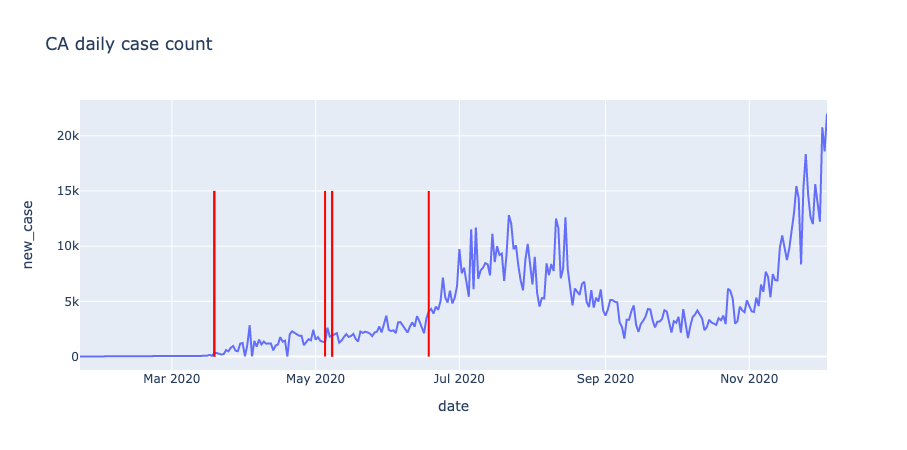

In [40]:
CA_fig = px.line(CA_case_count, x = CA_case_count['date'], y = CA_case_count['new_case'], 
                 title='CA daily case count')
CA_main_policy = state_mandate[state_mandate['state'] == 'CA']
for date in CA_main_policy['date']:
    CA_fig.add_shape(type='line',
                    x0=date,
                    y0=0,
                    x1=date,
                    y1=15000,
                    line=dict(color='Red',),
                    xref='x',
                    yref='y'
    ) 
CA_fig.show()

## Dashboard creating

In [201]:
## create the app
app = JupyterDash(__name__)

In [202]:
## create the app layout: it includes two of the three components of dash: plotly figure and dash core components.
## App layout
app.layout = html.Div([
    
    html.H1("Covid-policy Visualization", style={'text-align':'center'}),
    
    html.Div([
        dcc.Slider(id="slct_month",
               min=state_count_monthly['month'].min(),
               max=state_count_monthly['month'].max(),
               value=state_count_monthly['month'].min(),
               marks={i: '{}'.format(i) for i in range(1, 13)} 
        ),
        dcc.RadioItems(id='choro_case_death',
                       options=[{'label': i, 'value': i} for i in ['new_case', 'new_death']],
                       value='new_case',
                       labelStyle={'display':'inline-block'}
                      )
    ]),
          
    html.Div([
        dcc.Graph(id='state_choropleth')
    ]),
    
    html.Label("Line plot for the chosen states"),
    
    html.Div(["User's input: ",
        dcc.Input(id="state_input_1", type='text', value='CA'),
        dcc.Input(id="state_input_2", type='text', value='TX'),
        html.Button(id='submit_button', n_clicks=0, children = 'Submit'),
        html.Br(),
        dcc.RadioItems(id='line_case_death',
                       options=[{'label': i, 'value': i} for i in ['new_case', 'new_death']],
                       value='new_case',
                       labelStyle={'display':'inline-block'}
                      )
        
    ],
    style={
        'borderBottom': 'thin lightgrey solid',
        'backgroundColor': 'rgb(250, 250, 250)',
        'padding': '10px 5px'}),
    
    html.Div([
        dcc.Graph(id='line_plot_1')
    ],
    style={'width':'49%','display':'inline-block'}),
    
    html.Div([
        dcc.Graph(id='line_plot_2')
    ],
    style={'width':'49%','display':'inline-block','float':'right'})
    
])

In [203]:
## connect the dash components with plotly graph by callback
@app.callback(
    Output(component_id='state_choropleth', component_property='figure'),
    Input(component_id='slct_month', component_property='value'),
    Input(component_id='choro_case_death', component_property='value')
)
def update_choropleth_graph(option_slctd, click):
    
    state_count_monthly_cp = state_count_monthly.copy()
    state_count_monthly_cp = state_count_monthly_cp[state_count_monthly_cp['month'] == option_slctd]
    
    fig = px.choropleth(state_count_monthly_cp, 
                        color = click, 
                        locations='state', 
                        locationmode="USA-states", 
                        scope="usa")
    
    fig.update_layout(transition_duration=500)
    
    return fig

@app.callback(
    Output(component_id='line_plot_1', component_property='figure'),
    Output(component_id='line_plot_2', component_property='figure'),
    Input(component_id='line_case_death', component_property='value'),
    Input(component_id='submit_button', component_property='n_clicks'),
    State(component_id='state_input_1', component_property='value'),
    State(component_id='state_input_2', component_property='value')
)
def update_lineplot_graph(click, n_clicks, input1, input2):
    color = ['black', 'brown', 'aqua', 'green','grey', 'yellowgreen', 'red']
    
    state_count_cp = state_count.copy()
    state_count_cp_1 = state_count_cp[state_count_cp["state"] == input1]
    state_count_cp_2 = state_count_cp[state_count_cp["state"] == input2]
    
    state_mandate_cp = state_mandate.copy()
    state_mandate_cp_1 = state_mandate_cp[state_mandate_cp["state"] == input1]
    state_mandate_cp_2 = state_mandate_cp[state_mandate_cp["state"] == input2]
    
    fig1 = go.Figure()
    fig1.add_traces(go.Scatter(x=state_count_cp_1['date'], y=state_count_cp_1[click],
                    mode='lines', name=click + " count"))
    
    i = 0
    count = state_count_cp_1[click].tolist()
    count.sort()
    for date in state_mandate_cp_1['date']:
        mandate = state_mandate_cp_1[state_mandate_cp_1['date']==date]['policy_type'].tolist()
        fig1.add_traces(go.Scatter(
            x=[date, date],
            y=[0, count[-1]], 
            line={
                'color':color[i],
                'width': 2,
                'dash': 'dashdot',
            }, 
            name=mandate[0]
        ))
        i += 1

    fig2 = go.Figure()
    fig2.add_traces(go.Scatter(x=state_count_cp_2['date'], y=state_count_cp_2[click],
                    mode='lines'))
    
    i = 0
    count = state_count_cp_2[click].tolist()
    count.sort()
    for date in state_mandate_cp_2['date']:
        mandate = state_mandate_cp_2[state_mandate_cp_2['date']==date]['policy_type'].tolist()
        fig2.add_traces(go.Scatter(
            x=[date, date],
            y=[0, count[-1]], 
            line={
                'color':color[i],
                'width': 2,
                'dash': 'dashdot',
            }, 
            name=mandate[0]
        ))
        i += 1

    return fig1, fig2

In [204]:
app.run_server(mode='jupyterlab',debug = True, dev_tools_hot_reload=True)